выведение количества данных

Exibindo a quantidade de dados

Balanciamento de dados

In [1]:
import torch
import pandas as pd
import numpy as np
import time
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("/home/nail/Documents/Natalia/IoT/Datas/CIC_IOT_Dataset2023/IoT_Intrusion/IoT_Intrusion.csv")

In [3]:
df = df.dropna()

In [4]:
X = df[df.columns[0:-1]].fillna(0).reset_index(drop=True)
y = df['label']== 'BenignTraffic'

In [5]:
# Splitting data to train val test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=5)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=5)

# Удаление константных признаков
selector_var = VarianceThreshold(threshold=0)  # Удаление признаков с нулевой дисперсией
X_train = selector_var.fit_transform(X_train)
X_val = selector_var.transform(X_val)
X_test = selector_var.transform(X_test)

# Преобразование данных в тензоры для PyTorch
train_input = torch.tensor(X_train, dtype=torch.float32)
train_label = torch.tensor(y_train.to_numpy(), dtype=torch.long)
val_input = torch.tensor(X_val, dtype=torch.float32)
val_label = torch.tensor(y_val.to_numpy(), dtype=torch.long)
test_input = torch.tensor(X_test, dtype=torch.float32)
test_label = torch.tensor(y_test.to_numpy(), dtype=torch.long)

# Проверка размеров полученных выборок
print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")


Train size: 734002
Validation size: 157286
Test size: 157287


In [6]:
# Проверка баланса классов в обучающей, валидационной и тестовой выборках
print("Class distribution in training set:")
print(y_train.value_counts())

print("\nClass distribution in validation set:")
print(y_val.value_counts())

print("\nClass distribution in test set:")
print(y_test.value_counts())


Class distribution in training set:
label
False    716842
True      17160
Name: count, dtype: int64

Class distribution in validation set:
label
False    153578
True       3708
Name: count, dtype: int64

Class distribution in test set:
label
False    153679
True       3608
Name: count, dtype: int64


In [7]:
# Проверка баланса классов с PyTorch
train_class_counts = torch.bincount(train_label)
val_class_counts = torch.bincount(val_label)
test_class_counts = torch.bincount(test_label)

print(f"Class distribution in training set: {train_class_counts}")
print(f"Class distribution in validation set: {val_class_counts}")
print(f"Class distribution in test set: {test_class_counts}")


Class distribution in training set: tensor([716842,  17160])
Class distribution in validation set: tensor([153578,   3708])
Class distribution in test set: tensor([153679,   3608])


A distribuição das classes mostra um desequilíbrio significativo entre as classes:

 No conjunto de treinamento: 716.842 Exemplos da classe falsa em relação a 17.160 exemplos da verdadeira classe. 
 
 Estes são aproximadamente 97,7% dos exemplos para a classe falsa e apenas 2,3% para a classe verdadeira.
 
 No conjunto de validação: um desequilíbrio semelhante com 97,6% e 2,4%.
 
 Em um conjunto de testes: o desequilíbrio também persiste com 97,7% e 2,3%.


In [8]:
# Отбор признаков
N = 10  # Количество отбираемых признаков
selector = SelectKBest(f_classif, k=N)
X_train_selected = selector.fit_transform(X_train, y_train)
X_val_selected = selector.transform(X_val)
X_test_selected = selector.transform(X_test)

# Обучение модели с взвешиванием классов
model = RandomForestClassifier(class_weight='balanced')
model.fit(X_train_selected, y_train)

# Прогнозирование на валидационных данных
y_pred = model.predict(X_val_selected)

# Оценка точности
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy with top {N} features: {accuracy:.4f}")

# Замер времени обучения
start_train_time = time.perf_counter()
model.fit(X_train_selected, y_train)
end_train_time = time.perf_counter()

# Замер времени предсказания
start_predict_time = time.perf_counter()
y_pred_logreg = model.predict(X_val_selected)
end_predict_time = time.perf_counter()

# Проверка размеров предсказанных и истинных меток
print(f"Dimensions y_val: {y_val.shape}, y_pred_logreg: {y_pred_logreg.shape}")

# Вывод времени выполнения
print(f"Training time: {end_train_time - start_train_time:.4f} seconds")
print(f"Prediction time: {end_predict_time - start_predict_time:.4f} seconds")

Accuracy with top 10 features: 0.9910
Dimensions y_val: (157286,), y_pred_logreg: (157286,)
Training time: 40.1430 seconds
Prediction time: 0.6761 seconds


In [9]:

# Расчёт F1-score
f1 = f1_score(y_val, y_pred)
print(f"F1-score: {f1:.4f}")


F1-score: 0.8104


In [10]:
# Прогнозирование на валидационных данных
y_pred = model.predict(X_val_selected)
y_pred_prob = model.predict_proba(X_val_selected)[:, 1]  # Вероятности для положительного класса

# Расчёт AUC-ROC
auc_roc = roc_auc_score(y_val, y_pred_prob)
print(f"AUC-ROC: {auc_roc:.4f}")# Расчёт точности для каждого класса
precision = precision_score(y_val, y_pred, average=None)
print(f"Precision for each class: {precision}")


AUC-ROC: 0.9972
Precision for each class: [0.99544152 0.80730005]


In [11]:
# Вывод отчёта о классификации для каждого класса (включая precision, recall, F1-score)
print("\nClassification Report:")
print(classification_report(y_val, y_pred))



Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00    153578
        True       0.81      0.81      0.81      3708

    accuracy                           0.99    157286
   macro avg       0.90      0.90      0.90    157286
weighted avg       0.99      0.99      0.99    157286



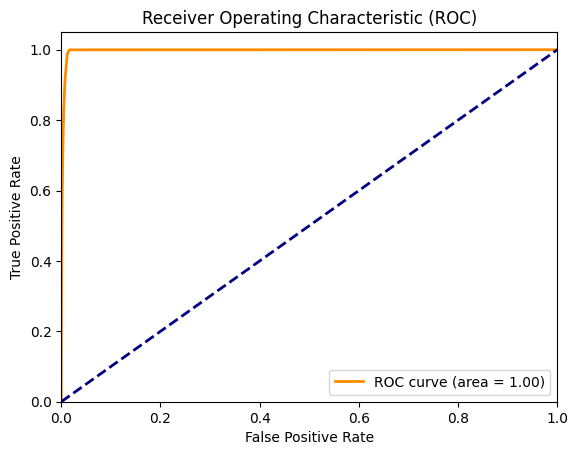

In [12]:
# Построение графика ROC-кривой
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

Logistic Regression:
              precision    recall  f1-score   support

       False       0.99      0.99      0.99    153679
        True       0.55      0.52      0.53      3608

    accuracy                           0.98    157287
   macro avg       0.77      0.76      0.76    157287
weighted avg       0.98      0.98      0.98    157287

F1-score: 0.5332
AUC-ROC: 0.6258
Precision for each class: [0.98874907 0.54675211]


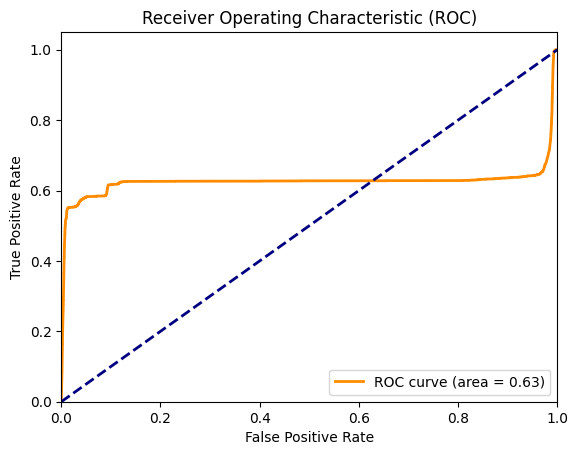

Training time: 16.2052 seconds
Prediction time: 0.0323 seconds


In [13]:
import time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Замер времени обучения
start_train_time = time.perf_counter()
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
end_train_time = time.perf_counter()

# Прогнозирование на тестовых данных и замер времени
start_predict_time = time.perf_counter()
y_pred_logreg = logreg.predict(X_test)
y_pred_prob_logreg = logreg.predict_proba(X_test)[:, 1]  # Вероятности для AUC-ROC
end_predict_time = time.perf_counter()

# Оценка метрик
print("Logistic Regression:")
print(classification_report(y_test, y_pred_logreg))

# Расчёт F1-score
f1_logreg = f1_score(y_test, y_pred_logreg)
print(f"F1-score: {f1_logreg:.4f}")

# Расчёт AUC-ROC
auc_roc_logreg = roc_auc_score(y_test, y_pred_prob_logreg)
print(f"AUC-ROC: {auc_roc_logreg:.4f}")

# Расчёт точности для каждого класса
precision_logreg = precision_score(y_test, y_pred_logreg, average=None)
print(f"Precision for each class: {precision_logreg}")

# Построение графика ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_logreg)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Время обучения и предсказания
print(f"Training time: {end_train_time - start_train_time:.4f} seconds")
print(f"Prediction time: {end_predict_time - start_predict_time:.4f} seconds")


Random Forest:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00    153679
        True       0.94      0.94      0.94      3608

    accuracy                           1.00    157287
   macro avg       0.97      0.97      0.97    157287
weighted avg       1.00      1.00      1.00    157287

F1-score: 0.9364
AUC-ROC: 0.9995
Precision for each class: [0.9984969  0.93675451]


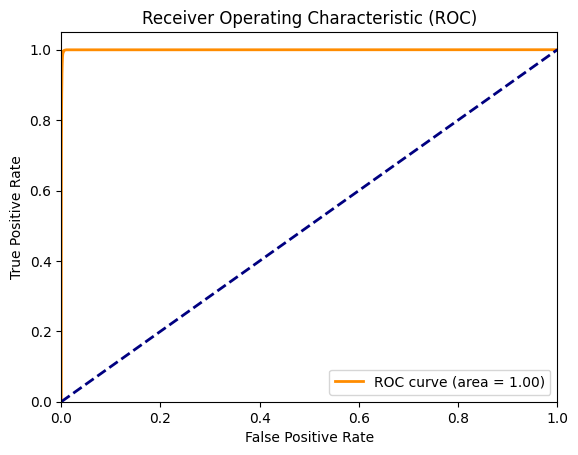

Training time: 68.8514 seconds
Prediction time: 1.4566 seconds


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Замер времени обучения
start_train_time = time.perf_counter()
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train, y_train)
end_train_time = time.perf_counter()

# Прогнозирование на тестовых данных и замер времени
start_predict_time = time.perf_counter()
y_pred_rf = rf.predict(X_test)
y_pred_prob_rf = rf.predict_proba(X_test)[:, 1]  # Вероятности для AUC-ROC
end_predict_time = time.perf_counter()

# Оценка метрик
print("Random Forest:")
print(classification_report(y_test, y_pred_rf))

# Расчёт F1-score
f1_rf = f1_score(y_test, y_pred_rf)
print(f"F1-score: {f1_rf:.4f}")

# Расчёт AUC-ROC
auc_roc_rf = roc_auc_score(y_test, y_pred_prob_rf)
print(f"AUC-ROC: {auc_roc_rf:.4f}")

# Расчёт точности для каждого класса
precision_rf = precision_score(y_test, y_pred_rf, average=None)
print(f"Precision for each class: {precision_rf}")

# Построение графика ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_rf)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Время обучения и предсказания
print(f"Training time: {end_train_time - start_train_time:.4f} seconds")
print(f"Prediction time: {end_predict_time - start_predict_time:.4f} seconds")


K-Nearest Neighbors (KNN):
              precision    recall  f1-score   support

       False       1.00      0.99      1.00    153679
        True       0.79      0.86      0.83      3608

    accuracy                           0.99    157287
   macro avg       0.90      0.93      0.91    157287
weighted avg       0.99      0.99      0.99    157287

F1-score: 0.8263
AUC-ROC: 0.9920
Precision for each class: [0.99671409 0.79487836]


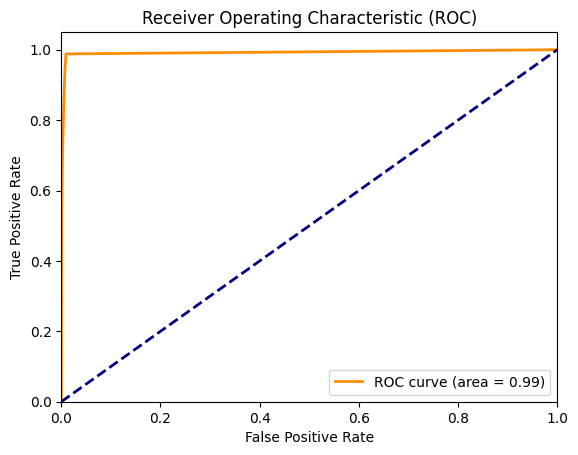

Training time: 0.1004 seconds
Prediction time: 390.6362 seconds


In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Замер времени обучения
start_train_time = time.perf_counter()
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
end_train_time = time.perf_counter()

# Прогнозирование на тестовых данных и замер времени
start_predict_time = time.perf_counter()
y_pred_knn = knn.predict(X_test)
y_pred_prob_knn = knn.predict_proba(X_test)[:, 1]  # Вероятности для AUC-ROC
end_predict_time = time.perf_counter()

# Оценка метрик
print("K-Nearest Neighbors (KNN):")
print(classification_report(y_test, y_pred_knn))

# Расчёт F1-score
f1_knn = f1_score(y_test, y_pred_knn)
print(f"F1-score: {f1_knn:.4f}")

# Расчёт AUC-ROC
auc_roc_knn = roc_auc_score(y_test, y_pred_prob_knn)
print(f"AUC-ROC: {auc_roc_knn:.4f}")

# Расчёт точности для каждого класса
precision_knn = precision_score(y_test, y_pred_knn, average=None)
print(f"Precision for each class: {precision_knn}")

# Построение графика ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_knn)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Время обучения и предсказания
print(f"Training time: {end_train_time - start_train_time:.4f} seconds")
print(f"Prediction time: {end_predict_time - start_predict_time:.4f} seconds")

Decision Tree:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00    153679
        True       0.92      0.91      0.91      3608

    accuracy                           1.00    157287
   macro avg       0.96      0.95      0.96    157287
weighted avg       1.00      1.00      1.00    157287

F1-score: 0.9138
AUC-ROC: 0.9517
Precision for each class: [0.99777557 0.92259887]


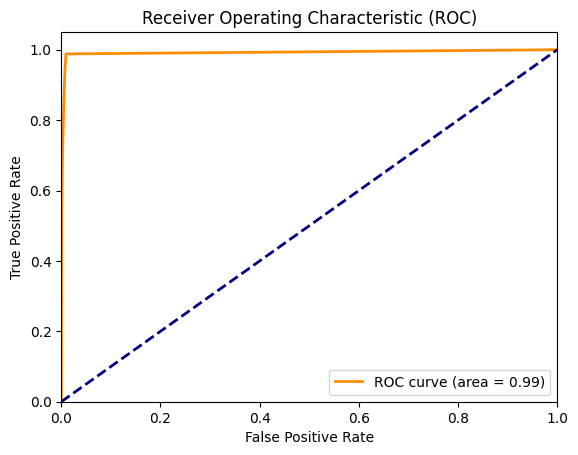

Training time: 6.1075 seconds
Prediction time: 0.0269 seconds


In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Замер времени обучения
start_train_time = time.perf_counter()
dt = DecisionTreeClassifier(class_weight='balanced')
dt.fit(X_train, y_train)
end_train_time = time.perf_counter()

# Прогнозирование на тестовых данных и замер времени
start_predict_time = time.perf_counter()
y_pred_dt = dt.predict(X_test)
y_pred_prob_dt = dt.predict_proba(X_test)[:, 1]  # Вероятности для AUC-ROC
end_predict_time = time.perf_counter()

# Оценка метрик
print("Decision Tree:")
print(classification_report(y_test, y_pred_dt))

# Расчёт F1-score
f1_dt = f1_score(y_test, y_pred_dt)
print(f"F1-score: {f1_dt:.4f}")

# Расчёт AUC-ROC
auc_roc_dt = roc_auc_score(y_test, y_pred_prob_dt)
print(f"AUC-ROC: {auc_roc_dt:.4f}")

# Расчёт точности для каждого класса
precision_dt = precision_score(y_test, y_pred_dt, average=None)
print(f"Precision for each class: {precision_dt}")

# Построение графика ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_knn)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Время обучения и предсказания
print(f"Training time: {end_train_time - start_train_time:.4f} seconds")
print(f"Prediction time: {end_predict_time - start_predict_time:.4f} seconds")


Gradient Boosting Classifier:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00    153679
        True       0.92      0.94      0.93      3608

    accuracy                           1.00    157287
   macro avg       0.96      0.97      0.96    157287
weighted avg       1.00      1.00      1.00    157287

F1-score: 0.9255
AUC-ROC: 0.9996
Precision for each class: [0.99848309 0.91587517]


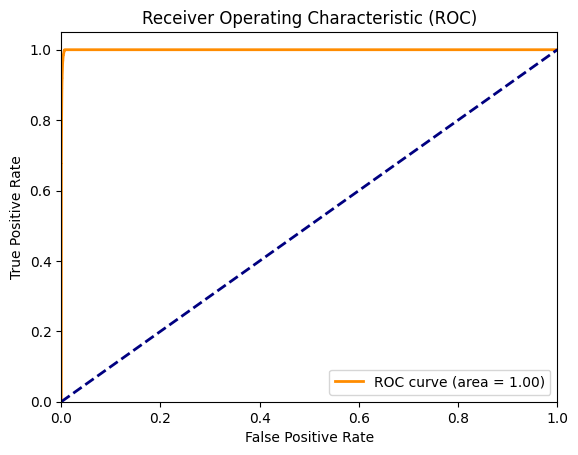

Training time: 271.9476 seconds
Prediction time: 0.3924 seconds


In [20]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, f1_score, precision_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import time

# Замер времени обучения
start_train_time = time.perf_counter()
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
end_train_time = time.perf_counter()

# Прогнозирование на тестовых данных и замер времени
start_predict_time = time.perf_counter()
y_pred_gb = gb.predict(X_test)
y_pred_prob_gb = gb.predict_proba(X_test)[:, 1]
end_predict_time = time.perf_counter()

# Оценка метрик
print("Gradient Boosting Classifier:")
print(classification_report(y_test, y_pred_gb))

# Расчёт F1-score
f1_gb = f1_score(y_test, y_pred_gb)
print(f"F1-score: {f1_gb:.4f}")

# Расчёт AUC-ROC
auc_roc_gb = roc_auc_score(y_test, y_pred_prob_gb)
print(f"AUC-ROC: {auc_roc_gb:.4f}")

# Расчёт точности для каждого класса
precision_gb = precision_score(y_test, y_pred_gb, average=None)
print(f"Precision for each class: {precision_gb}")

# Построение графика ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_gb)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Время обучения и предсказания
print(f"Training time: {end_train_time - start_train_time:.4f} seconds")
print(f"Prediction time: {end_predict_time - start_predict_time:.4f} seconds")

XGBoost:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00    153679
        True       0.90      0.94      0.92      3608

    accuracy                           1.00    157287
   macro avg       0.95      0.97      0.96    157287
weighted avg       1.00      1.00      1.00    157287

F1-score: 0.9238
AUC-ROC: 0.9994
Precision for each class: [0.99870371 0.90376458]


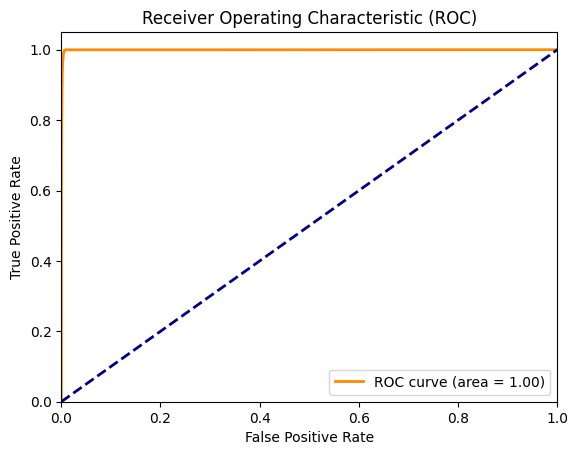

Training time: 3.0563 seconds
Prediction time: 0.1269 seconds


In [21]:
import xgboost as xgb
from sklearn.metrics import classification_report, f1_score, precision_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import time

# Замер времени обучения
start_train_time = time.perf_counter()
xgboost = xgb.XGBClassifier(eval_metric='logloss')  # Убрали параметр use_label_encoder
xgboost.fit(X_train, y_train)
end_train_time = time.perf_counter()

# Прогнозирование на тестовых данных и замер времени
start_predict_time = time.perf_counter()
y_pred_xgb = xgboost.predict(X_test)
y_pred_prob_xgb = xgboost.predict_proba(X_test)[:, 1]
end_predict_time = time.perf_counter()

# Оценка метрик
print("XGBoost:")
print(classification_report(y_test, y_pred_xgb))

# Расчёт F1-score
f1_xgb = f1_score(y_test, y_pred_xgb)
print(f"F1-score: {f1_xgb:.4f}")

# Расчёт AUC-ROC
auc_roc_xgb = roc_auc_score(y_test, y_pred_prob_xgb)
print(f"AUC-ROC: {auc_roc_xgb:.4f}")

# Расчёт точности для каждого класса
precision_xgb = precision_score(y_test, y_pred_xgb, average=None)
print(f"Precision for each class: {precision_xgb}")

# Построение графика ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_xgb)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Время обучения и предсказания
print(f"Training time: {end_train_time - start_train_time:.4f} seconds")
print(f"Prediction time: {end_predict_time - start_predict_time:.4f} seconds")


Naive Bayes:
              precision    recall  f1-score   support

       False       1.00      0.95      0.98    153679
        True       0.34      0.99      0.50      3608

    accuracy                           0.96    157287
   macro avg       0.67      0.97      0.74    157287
weighted avg       0.98      0.96      0.97    157287

F1-score: 0.5031
AUC-ROC: 0.9856
Precision for each class: [0.99982953 0.33690644]


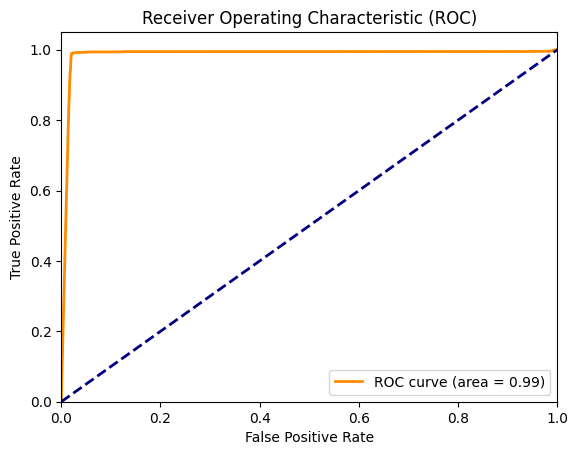

Training time: 0.4187 seconds
Prediction time: 0.1462 seconds


In [22]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, f1_score, precision_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import time

# Замер времени обучения
start_train_time = time.perf_counter()
nb = GaussianNB()
nb.fit(X_train, y_train)
end_train_time = time.perf_counter()

# Прогнозирование на тестовых данных и замер времени
start_predict_time = time.perf_counter()
y_pred_nb = nb.predict(X_test)
y_pred_prob_nb = nb.predict_proba(X_test)[:, 1]
end_predict_time = time.perf_counter()

# Оценка метрик
print("Naive Bayes:")
print(classification_report(y_test, y_pred_nb))

# Расчёт F1-score
f1_nb = f1_score(y_test, y_pred_nb)
print(f"F1-score: {f1_nb:.4f}")

# Расчёт AUC-ROC
auc_roc_nb = roc_auc_score(y_test, y_pred_prob_nb)
print(f"AUC-ROC: {auc_roc_nb:.4f}")

# Расчёт точности для каждого класса
precision_nb = precision_score(y_test, y_pred_nb, average=None)
print(f"Precision for each class: {precision_nb}")

# Построение графика ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_nb)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Время обучения и предсказания
print(f"Training time: {end_train_time - start_train_time:.4f} seconds")
print(f"Prediction time: {end_predict_time - start_predict_time:.4f} seconds")


AdaBoost:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00    153679
        True       0.90      0.94      0.92      3608

    accuracy                           1.00    157287
   macro avg       0.95      0.97      0.96    157287
weighted avg       1.00      1.00      1.00    157287

F1-score: 0.9228
AUC-ROC: 0.9993
Precision for each class: [0.9986257  0.90490144]


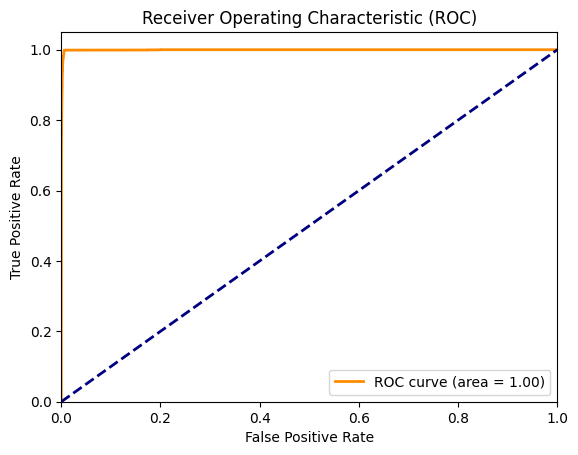

Training time: 120.6412 seconds
Prediction time: 3.6175 seconds


In [23]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, f1_score, precision_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import time

# Замер времени обучения
start_train_time = time.perf_counter()
adaboost = AdaBoostClassifier(n_estimators=100)  # Можно настроить n_estimators для улучшения
adaboost.fit(X_train, y_train)
end_train_time = time.perf_counter()

# Прогнозирование на тестовых данных и замер времени
start_predict_time = time.perf_counter()
y_pred_ada = adaboost.predict(X_test)
y_pred_prob_ada = adaboost.predict_proba(X_test)[:, 1]
end_predict_time = time.perf_counter()

# Оценка метрик
print("AdaBoost:")
print(classification_report(y_test, y_pred_ada))

# Расчёт F1-score
f1_ada = f1_score(y_test, y_pred_ada)
print(f"F1-score: {f1_ada:.4f}")

# Расчёт AUC-ROC
auc_roc_ada = roc_auc_score(y_test, y_pred_prob_ada)
print(f"AUC-ROC: {auc_roc_ada:.4f}")

# Расчёт точности для каждого класса
precision_ada = precision_score(y_test, y_pred_ada, average=None)
print(f"Precision for each class: {precision_ada}")

# Построение графика ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_ada)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Время обучения и предсказания
print(f"Training time: {end_train_time - start_train_time:.4f} seconds")
print(f"Prediction time: {end_predict_time - start_predict_time:.4f} seconds")


Multi-Layer Perceptron (MLP):
              precision    recall  f1-score   support

       False       0.98      1.00      0.99    153679
        True       0.00      0.00      0.00      3608

    accuracy                           0.98    157287
   macro avg       0.49      0.50      0.49    157287
weighted avg       0.95      0.98      0.97    157287

F1-score: 0.0000
AUC-ROC: 0.4957
Precision for each class: [0.97706075 0.        ]


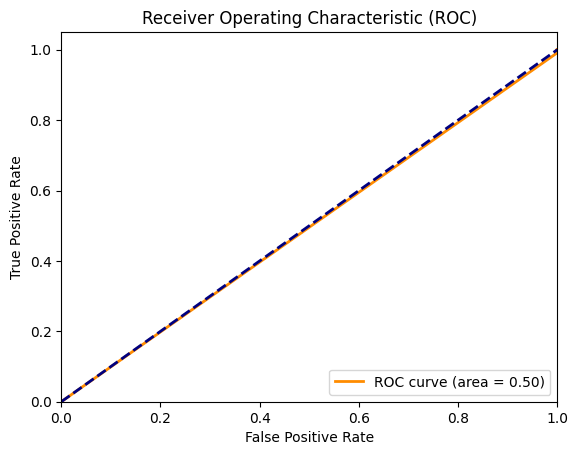

Training time: 470.2612 seconds
Prediction time: 1.7157 seconds


In [24]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, f1_score, precision_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import time

# Замер времени обучения
start_train_time = time.perf_counter()
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=5)  # Настройка параметров MLP
mlp.fit(X_train, y_train)
end_train_time = time.perf_counter()

# Прогнозирование на тестовых данных и замер времени
start_predict_time = time.perf_counter()
y_pred_mlp = mlp.predict(X_test)
y_pred_prob_mlp = mlp.predict_proba(X_test)[:, 1]  # Для AUC-ROC требуется вероятность положительного класса
end_predict_time = time.perf_counter()

# Оценка метрик
print("Multi-Layer Perceptron (MLP):")
print(classification_report(y_test, y_pred_mlp))

# Расчёт F1-score
f1_mlp = f1_score(y_test, y_pred_mlp)
print(f"F1-score: {f1_mlp:.4f}")

# Расчёт AUC-ROC
auc_roc_mlp = roc_auc_score(y_test, y_pred_prob_mlp)
print(f"AUC-ROC: {auc_roc_mlp:.4f}")

# Расчёт точности для каждого класса
precision_mlp = precision_score(y_test, y_pred_mlp, average=None)
print(f"Precision for each class: {precision_mlp}")

# Построение графика ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_mlp)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Время обучения и предсказания
print(f"Training time: {end_train_time - start_train_time:.4f} seconds")
print(f"Prediction time: {end_predict_time - start_predict_time:.4f} seconds")
